# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Структура работы

1. [Знакомство с данными, изучение общей информации](#intro)
2. [Предобработка данных](#preprocessing)
 - [Обработка дубликатов](#preprocessing_duplicates)
 - [Изучение распределений и обработка ошибок в данных](#preprocessing_data_errors)
 - [Обработка пропусков](#preprocessing_missing)
 - [Замена типов данных](#preprocessing_types)
 - [Лемматизация](#preprocessing_lemmatization)
 - [Категоризация данных](#preprocessing_categorization)
 
3. [Ответы на вопросы заказчика](#questions_and_answers)
4. [Общий вывод](#conclusion)


## 1. Знакомство с данными, изучение общей информации <a name="intro"></a>

In [1]:
# обновляем версию Seaborn
!pip install -U seaborn

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.1)


In [2]:
# импортируем библиотеки
# работа с таблицамими, вычисления
import numpy as np
import pandas as pd

# визуализация
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# параметры визуализации
sns.set_context(
    "notebook", 
    font_scale=1.5,       
    rc={ 
        "figure.figsize": (11, 8), 
        "axes.titlesize": 18 
    }
)
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

# лемматизация
from pymystem3 import Mystem

# игнорируем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [56]:
# читаем файл с данными и сохраняем в переменную
initial_data = pd.read_csv('/datasets/data.csv') 
# посмотрим на данные
print('Размерность данных:', initial_data.shape)
initial_data.head(10)

Размерность данных: (21525, 12)


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


Описание данных
- children — количество детей в семье
- days_employed — общий трудовой стаж в днях
- dob_years — возраст клиента в годах
- education — уровень образования клиента
- education_id — идентификатор уровня образования
- family_status — семейное положение
- family_status_id — идентификатор семейного положения
- gender — пол клиента
- income_type — тип занятости
- debt — имел ли задолженность по возврату кредитов
- total_income — ежемесячный доход
- purpose — цель получения кредита

In [4]:
# посмотрим на типы данных в таблице и используемую память
initial_data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 11.3 MB


In [5]:
# посмотрим на распределение значений в данных
initial_data.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


### Вывод

Уже на этапе ознакомления с данными можем выделить ряд ошибок в данных и задач:
- отрицательные значения в столбцах `[children]` и `[days_employed]`;
- разный регистр строковых значений в столбце `[education]`;
- необходима лемматизация столбца `[purpose]`;
- пропущенные значения в столбцах: `[days_employed]` и `[total_income]`. Причем количество пропусков одинаковое. Оба признака связаны между собой. Это значит, что пропуски в данных в обоих случаях, вероятно, имеют одинаковую природу;
- максимальное значение в столбце `[children]` равно 20, нужно проверить;
- в столбце `[dob_years]` (возраст клиента) есть по крайней мере одно значение, равное 0.

Про типы данных и `info()`:
- использование памяти (11.3 MB) небольшое. В рамках задачи можно проигнорировать оптимизацию памяти.
- категориальные и количественные столбцы имеют соответствующий тип данных (object и int/float соответственно). Однако столбец `[debt]` имеет тип данных int вместо bool, а также ряд float столбцов нужно будет поменять на int. Посмотрим на это подробнее позже и по мере необходимости исправим.

## 2. Предобработка данных <a name="preprocessing"></a>

### 2.1. Обработка дубликатов <a name="preprocessing_duplicates"></a>

В первую очередь разберемся с самым простым — явными дубликатами.

In [6]:
# создадим копию датафрйема, которую будем редактировать далее
data = initial_data.copy()

In [7]:
# приведем категориальные признаки к единому регистру для выявления дубликатов
data['education'] = data['education'].str.lower()
data['family_status'] = data['family_status'].str.lower()
data['income_type'] = data['income_type'].str.lower()
data['gender'] = data['gender'].str.upper()
data['purpose'] = data['purpose'].str.lower()
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,среднее,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,высшее,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [8]:
# проверим дубликаты
data.duplicated().sum()

71

Дубликатов немного (~0.3% от всех записей), однако они могут немного искажать информацию при расчете сводных статистик по всей выборке и достаточно сильно искажать информацию, если попадут в неслабалансированные группы (например небольшая группа безработных будет состоять на половину из дубликатов). Поэтому мы избавимся от них.

Дубликаты могут появляться при интеграция данных из различных источников, слиянии таблиц и других видах трансформации данных. Кроме этого, дубликаты могут появляться при неудачно выбранном алгоритме выборки (например, когда одно и то же наблюдение извлекается несколько раз при использовании выборки с возвратом).

In [10]:
# удаляем дупликаты и переназначаем индексы
data = data.drop_duplicates().reset_index(drop=True)
# провреяем наличие дупликатов после удаления
data.duplicated().sum()

0

### Вывод

Данные имели явные дубликаты и мы от них избавились. Передадим информацию о наличии дубликатов коллегам, чтобы выяснить, на каком этапе они возникают.

### 2.2. Изучение распределений и обработка ошибок в данных <a name='preprocessing_data_errors'></a>

Ранее мы уже обнаружили отрицательные значения в столбцах `[children]` и `[days_employed]`, теперь нужно с ними разобраться и взглянуть на распределения значений в остальных столбцах, чтобы выявить другие аномалии/ошибки.

In [11]:
# посмотрим на распределение значений в количестве детей [children]
data['children'].value_counts()

 0     14091
 1      4808
 2      2052
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Мы видим, что посреди нормальных значений (от 0 до 5 детей) закрались множественные аномалии со значениями **20** и **-1**. При этом эти значения не являются дубпликатами друг друга. В связи с этим:
- в случае со значением **20**: будем исходить из предположения, что ошибка заключается в случайном лишнем нуле, поэтому все значения **20** преобразуем в значение **2**. Даже если это гипотеза не верна, то **2** достаточно распространенное значение для столбца и не будет сильно искажать статистику;
- в случае со значением **-1**: будем исходить из предположения об ошибке в знаке. Поэтому **-1** заменяем на **1**.

Также передадим коллегам факт наличия такой ошибки, чтобы в будущем подтягивать корректные данные.

In [12]:
# меняем ошибочные значения
data.loc[data['children'] == 20, 'children'] = 2
data.loc[data['children'] == -1, 'children'] = 1

# проверим изменения
data['children'].value_counts()

0    14091
1     4855
2     2128
3      330
4       41
5        9
Name: children, dtype: int64

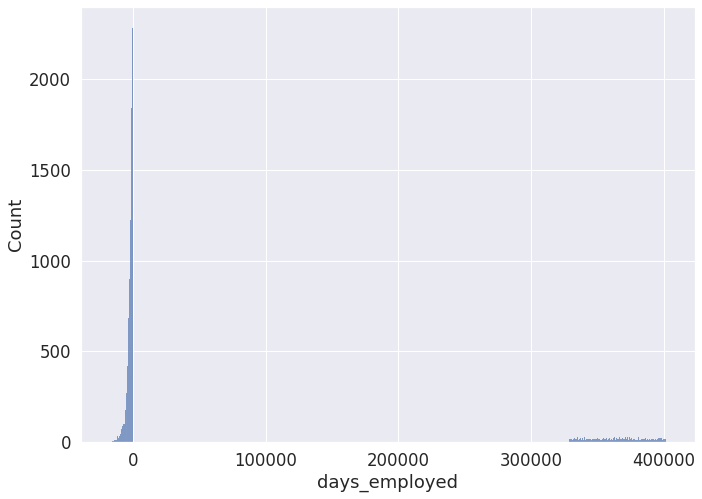

In [13]:
# посмотрим на распределение значений стажа
sns.histplot(data['days_employed'], binwidth=365);

- Левая часть графика имеет имеет нормальный, но 'отзеркаленый' вид (все значения со знаком минус, хотя должно быть положительными). Это можно легко исправить, приведя значения к абсолютным.
- В глаза так же бросаются многочисленные наблюдения, начинающиеся приблизительно со значения 325 000 (более 800 лет стажа) по оси X.

In [14]:
# посмотрим строки с этими значениями
data[data['days_employed'] > 325000]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
18,0,400281.136913,53,среднее,1,вдовец / вдова,2,F,пенсионер,0,56823.777243,на покупку подержанного автомобиля
24,1,338551.952911,57,среднее,1,не женат / не замужем,4,F,пенсионер,0,290547.235997,операции с коммерческой недвижимостью
25,0,363548.489348,67,среднее,1,женат / замужем,0,M,пенсионер,0,55112.757732,покупка недвижимости
30,1,335581.668515,62,среднее,1,женат / замужем,0,F,пенсионер,0,171456.067993,операции с коммерческой недвижимостью
...,...,...,...,...,...,...,...,...,...,...,...,...
21434,0,338904.866406,53,среднее,1,гражданский брак,1,M,пенсионер,0,75439.993167,сыграть свадьбу
21437,0,386497.714078,62,среднее,1,женат / замужем,0,M,пенсионер,0,72638.590915,недвижимость
21438,0,362161.054124,59,высшее,0,женат / замужем,0,M,пенсионер,0,73029.059379,операции с недвижимостью
21447,0,373995.710838,59,среднее,1,женат / замужем,0,F,пенсионер,0,153864.650328,сделка с автомобилем


3445 строк с невозможным стажем — это много. Причем на первый взгляд в данном срезе одни пенсионеры.

In [15]:
# проверим распределение этих значений по группам [income_type]
data[data['days_employed'] > 325000]['income_type'].value_counts()

пенсионер      3443
безработный       2
Name: income_type, dtype: int64

Более 99.9% аномального стажа - это пенсионеры. Причем эти строки составляют внушительные ~16% всех записей (и большую часть всех пенсионеров). По итогу, столбец стажа `[days_employed]` имеет ряд ошибок в данных:
- большое количество значений с невозможным (800+ лет) стажем;
- отрицательные значения;
- все значения имеют цифры после запятой (стаж не может быть вещественным числом);
- пропущенные значения.

На этом этапе мы сообщим об этих серьезных ошибках в данных нашим коллегам. Далее целесообразно будет игнорирровать этот столбец, поскольку он не важен для дальнейшего исследования, а его предобработка может занять много времени и не дать по итогу результата.

In [16]:
# избавляемся от столбца
data = data.drop(columns='days_employed')
# проверим
data.head()

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


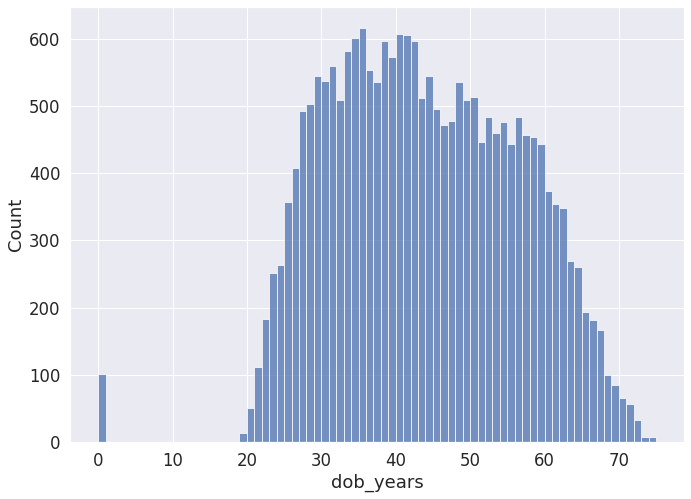

In [17]:
# проверим распределение возраста клиентов
sns.histplot(data['dob_years'], binwidth=1);

В целом распределение выглядит нормальным, за исключением явных аномалий в ~100 наблюдениях в графике слева, где возраст клиентов равен 0. Это равносильно пропускам в данных. Неободимо заменить эти значения на этапе обработке пропусков.

In [18]:
# посмотрим на распределение значений в образовании
data['education'].value_counts()

среднее                15172
высшее                  5250
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

Данные об образовании не требуют обработки.

In [19]:
data['education_id'].value_counts()

1    15172
0     5250
2      744
3      282
4        6
Name: education_id, dtype: int64

Значения `[education_id]` соответствуют значениям `[education]`, однако мы можем изменить идентификаторы образования по принципу упорядочивания, от наименьшего образования (начальное: 0) к наивысшему (ученая степень: 4). Такая замена обоснована, поскольку она косвенно говорит о количественной переменной, условно насколько 'много часов' было затрачено человеком на образование, поэтому данная категория является порядковой. Это может быть полезно в методах `describe()` и `corr()` и прочих сводных статистиках. По этой же причине мы оставим этот столбец в данных, не смотря на то что он дублирует `[education]`.

In [20]:
# упорядочим идентификаторы образования
data.loc[data['education_id'] == 3, 'education_id'] = 10
data.loc[data['education_id'] == 0, 'education_id'] = 3
data.loc[data['education_id'] == 10, 'education_id'] = 0
# проверим изменения
data['education_id'].value_counts()

1    15172
3     5250
2      744
0      282
4        6
Name: education_id, dtype: int64

In [21]:
# посмотрим на распределение значений в семейном статусе
data['family_status'].value_counts()

женат / замужем          12339
гражданский брак          4151
не женат / не замужем     2810
в разводе                 1195
вдовец / вдова             959
Name: family_status, dtype: int64

Данные не требуют обработки.

In [22]:
data['family_status_id'].value_counts()

0    12339
1     4151
4     2810
3     1195
2      959
Name: family_status_id, dtype: int64

Значения `[family_status_id]` соответствуют значениям `[family_status]`. Далее нам не интерес столбец c id, поскольку он не несет дополнительной информации. Мы уберем его из данных, но сохраним словарь значений в формате `{family_status_id: family_status}` на случай, если нам вдруг понадобится именно старые id категорий семейного статуса.

In [23]:
# выделяем словарь на основе фрейма
family_status_dict = data[['family_status_id', 'family_status']].set_index(
    'family_status_id').T.to_dict('list');
family_status_dict

{0: ['женат / замужем'],
 1: ['гражданский брак'],
 2: ['вдовец / вдова'],
 3: ['в разводе'],
 4: ['не женат / не замужем']}

In [24]:
# дропаем столбец
data = data.drop(columns='family_status_id')
# проверяем изменения
data.head()

,children,dob_years,education,education_id,family_status,gender,income_type,debt,total_income,purpose
0,1,42,высшее,3,женат / замужем,F,сотрудник,0,253875.639453,покупка жилья
1,1,36,среднее,1,женат / замужем,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,33,среднее,1,женат / замужем,M,сотрудник,0,145885.952297,покупка жилья
3,3,32,среднее,1,женат / замужем,M,сотрудник,0,267628.550329,дополнительное образование
4,0,53,среднее,1,гражданский брак,F,пенсионер,0,158616.077870,сыграть свадьбу


In [25]:
# посмотрим на распределение значений в гендере
data['gender'].value_counts()

F      14174
M       7279
XNA        1
Name: gender, dtype: int64

- есть всего одно необычное значение гендера, равное 'XNA' (поиск в интернете не дал информации). Пока можно не трогать, однако стоит уточнить у коллег и исправить, если это ошибка; 
- наблюдается скорее всего неслучайный перекос в сторону клиентов-женщин (почти 2 к 1). Это может быть как инсайтом, так и фактором нерепрезентативности данных. Стоит выяснить у коллег.

In [26]:
# посмотрим на распределение значений в типе дохода
data['income_type'].value_counts()

сотрудник          11084
компаньон           5078
пенсионер           3829
госслужащий         1457
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: income_type, dtype: int64

Не совсем ясно, что подразумевается под компаньоном. Крайне мало значений предприниматель/безработный/студент/в декрете. Данные не требуют обработки.

In [27]:
# посмотрим на распределение значений в невозврате кредита
data['debt'].value_counts()

0    19713
1     1741
Name: debt, dtype: int64

Информация в этом столбце отвечает на вопрос да/нет (имел ли проблемы с оплатой кредита), однако мы не будем менять тип данных с int на bool, чтобы иметь возможность проводить с ним математические операции напрямую.

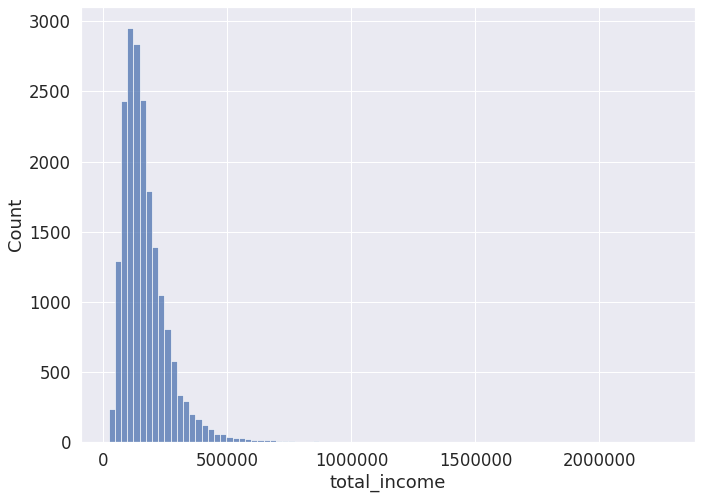

In [28]:
# посмотрим на распределение дохода
sns.histplot(data['total_income'], binwidth=25000);

Распределение доходов клиентов выглядит нормальным. Данные не требуют обработки. Однако помним о том, что данные имеют пропущенные значения. Взглянем на срез данных с пропущенными значениями в этом столбце и сравним со всей выборкой.

In [29]:
# сравним описательные статистики выборок
print('Описательная статистика всей выборки:')
display(data.describe())
print('Описательная статистика выборки, где значения дохода не указаны:')
data[data['total_income'].isna()].describe()

Описательная статистика всей выборки:


,children,dob_years,education_id,debt,total_income
count,21454.000000,21454.000000,21454.000000,21454.000000,1.935100e+04
mean,0.480563,43.271231,1.511793,0.081150,1.674223e+05
std,0.756069,12.570822,0.875947,0.273072,1.029716e+05
min,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,33.000000,1.000000,0.000000,1.030532e+05
50%,0.000000,42.000000,1.000000,0.000000,1.450179e+05
75%,1.000000,53.000000,2.000000,0.000000,2.034351e+05
max,5.000000,75.000000,4.000000,1.000000,2.265604e+06


Описательная статистика выборки, где значения дохода не указаны:


,children,dob_years,education_id,debt,total_income
count,2103.000000,2103.000000,2103.000000,2103.000000,0.0
mean,0.489301,43.417499,1.530670,0.080837,NaN
std,0.775919,12.495774,0.881616,0.272649,NaN
min,0.000000,0.000000,0.000000,0.000000,NaN
25%,0.000000,34.000000,1.000000,0.000000,NaN
50%,0.000000,43.000000,1.000000,0.000000,NaN
75%,1.000000,54.000000,3.000000,0.000000,NaN
max,5.000000,73.000000,3.000000,1.000000,NaN


In [30]:
# отобразим распределение типов занятости [income_type] обеих выборок
display(data['income_type'].value_counts())
data[data['total_income'].isna()]['income_type'].value_counts()

сотрудник          11084
компаньон           5078
пенсионер           3829
госслужащий         1457
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: income_type, dtype: int64

сотрудник          1070
компаньон           501
пенсионер           386
госслужащий         145
предприниматель       1
Name: income_type, dtype: int64

Обе выборки не имеют значимого различия ни по количеству детей, ни по возрасту, ни по уровню образования, ни по распределению типа занятости. Выборки крайне однородны. Это косвенно говорит о том, что пропуски имеют случайную природу. К примеру, если бы доход был бы не указан из-за высоких значений (богатые люди более склонны не сообщать о своих доходах), руководящих должностей респондентов или NDA, то мы бы, вероятно, имели бы значимую разницу в качестве образования между этими выборками. Не имея такой разницы, мы можем с большей уверенностью заполнять пропуски в данных. Дополнимательным фактором в пользу этой гипотезы является предположение, что при получении кредита нельзя скрыть свой доход, иначе не ясно, как оценить заемщика.

Поэтому мы будем исходить из того, что пропуски обусловлены технической ошибкой (может быть, в одном из кредитных отделений банка/какие-то конкретные даты по всей сети/прочие причины).

In [31]:
# посмотрим на распределение значений в целях кредита
data['purpose'].value_counts()

свадьба                                   791
на проведение свадьбы                     768
сыграть свадьбу                           765
операции с недвижимостью                  675
покупка коммерческой недвижимости         661
операции с жильем                         652
покупка жилья для сдачи                   651
операции с коммерческой недвижимостью     650
покупка жилья                             646
жилье                                     646
покупка жилья для семьи                   638
строительство собственной недвижимости    635
недвижимость                              633
операции со своей недвижимостью           627
строительство жилой недвижимости          624
покупка недвижимости                      621
покупка своего жилья                      620
строительство недвижимости                619
ремонт жилью                              607
покупка жилой недвижимости                606
на покупку своего автомобиля              505
заняться высшим образованием      

Столбцу явно нужна лемматизация, иначе не получится сгруппировать клиентов по целям кредита. Это будет сделано в отдельном разделе, посвященном лемматизации.

### Вывод

Мы подробно изучили распределения значений столбцов, нашли ряд ошибок и исправили их. Также по итогам изучения мы наметили ряд задач, которые будут выполнены далее.

### 2.3. Обработка пропусков <a name='preprocessing_missing'></a>

Теперь мы можем приступить к разработке стратегии заполнения пропусков и самому заполнению. На данный момент у нас остались пропуски в `[total_income]`, а также около 100 нулевых значений в столбце `[dob_years]`. Посмотрим на матрицу корреляции числовых столбцов. Это может быть полезно для того, чтобы обоснованно выбрать стратегию заполнения пропусков в столбце (заполнение на основе регрессии).

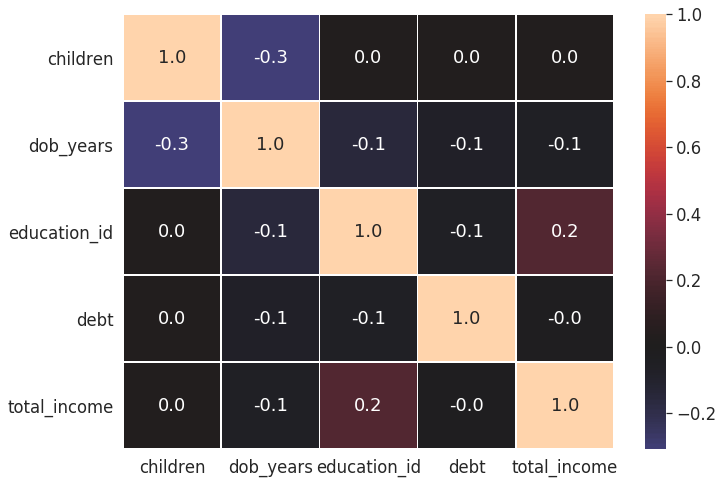

In [32]:
# посчитаем линейные корреляции Пирсона столбцов между собой
corr = data.corr()
# визуализируем тепловую карту корреляций между столбцами
sns.heatmap(corr, annot=True, fmt='.1f', linewidths=.5, center=0);

- слабая, но интуитивно понятная связь существует между `[education_id]` и `[total_icome]` (благодаря тому, что ранее мы упорядочили значения идентифкатора образования по возрастанию 'степени' образованности);
- интересно, что для таргет-столбца `[debt]` нет даже слабых предикторов среди данных признаков.
- существует контр-интуитивная слабая обратная связь между возрастом `[dob_years]` и количеством детей `[children]` (чем старше, тем меньше детей?)

Беглый анализ линейной корреляции **не дал значимой информации**. Поэтому в заполнении пропусков будем опираться на обычный здравый смысл:
- заполним пропуски в `[dob_years]` на основе `[income_type]`, т.к. в этом столбце есть информация о статусе пенсионера/не пенсионера, являющаяся естественным предиктором возраста.
- пропуски в `[total_income]` заполним на основе `[education_id]` и `[income_type]`, т.к. образование и тип занятости должны наиболее сильно влиять на уровень доходов.

In [33]:
# явно укажем, что нулевые значения dob_years это пропуски
data.loc[data['dob_years'] == 0, 'dob_years'] = np.NAN
data.isna().sum()

children            0
dob_years         101
education           0
education_id        0
family_status       0
gender              0
income_type         0
debt                0
total_income     2103
purpose             0
dtype: int64

In [34]:
# заменим пропущенные значения возраста [dob_years] по медианам категорий столбца [income_type]
print('Проверка:')
for type in data['income_type'].unique():
    median = data[data['income_type'] == type]['dob_years'].median()
    print('Медиана категории', type, median, 'лет')
    data.loc[(data['dob_years'].isna()) &
             (data['income_type'] == type),
             'dob_years'] = median

# проверим изменения
data.isna().sum()

Проверка:
Медиана категории сотрудник 39.0 лет
Медиана категории пенсионер 60.0 лет
Медиана категории компаньон 39.0 лет
Медиана категории госслужащий 40.0 лет
Медиана категории безработный 38.0 лет
Медиана категории предприниматель 42.5 лет
Медиана категории студент 22.0 лет
Медиана категории в декрете 39.0 лет


children            0
dob_years           0
education           0
education_id        0
family_status       0
gender              0
income_type         0
debt                0
total_income     2103
purpose             0
dtype: int64

In [35]:
# сгруппируем данные по столбцам [income_type] и [education_id] 
# и посчитаем для них медиану по столбцу [total_income]
grouped_data = data.groupby(
    ['income_type', 'education_id']).agg(
    {'total_income':'median'}).rename(
    columns = {'total_income':'median_income'})

grouped_data.head(10)

median_income
income_type education_id               
безработный 1              59956.991984
            3             202722.511368
в декрете   1              53829.130729
госслужащий 0             148339.290825
            1             136652.970357
            2             160592.345303
            3             172511.107016
            4             111392.231107
компаньон   0             136798.905143
            1             159070.690289

In [36]:
# пристегиваем сгруппированные данные к основной таблице
data = data.merge(grouped_data, on=['income_type', 'education_id'])
data.head()

,children,dob_years,education,education_id,family_status,gender,income_type,debt,total_income,purpose,median_income
0,1,42.0,высшее,3,женат / замужем,F,сотрудник,0,253875.639453,покупка жилья,165640.744634
1,2,35.0,высшее,3,гражданский брак,F,сотрудник,0,95856.832424,на проведение свадьбы,165640.744634
2,0,33.0,высшее,3,гражданский брак,M,сотрудник,0,90410.586745,строительство недвижимости,165640.744634
3,0,21.0,высшее,3,гражданский брак,M,сотрудник,0,128265.720871,сыграть свадьбу,165640.744634
4,0,28.0,высшее,3,женат / замужем,M,сотрудник,0,308848.983691,строительство собственной недвижимости,165640.744634


In [37]:
# заполняем пропуски в [total_income] значениями из [median_income]
data.loc[data['total_income'].isna(), 'total_income'] = data.loc[data['total_income'].isna(), 'median_income']
# проверяем изменения
data.isna().sum()

children         0
dob_years        0
education        0
education_id     0
family_status    0
gender           0
income_type      0
debt             0
total_income     0
purpose          0
median_income    0
dtype: int64

In [38]:
# избавляемся от вспомогательного столбца [median_income]
data = data.drop(columns='median_income')
data.head()

,children,dob_years,education,education_id,family_status,gender,income_type,debt,total_income,purpose
0,1,42.0,высшее,3,женат / замужем,F,сотрудник,0,253875.639453,покупка жилья
1,2,35.0,высшее,3,гражданский брак,F,сотрудник,0,95856.832424,на проведение свадьбы
2,0,33.0,высшее,3,гражданский брак,M,сотрудник,0,90410.586745,строительство недвижимости
3,0,21.0,высшее,3,гражданский брак,M,сотрудник,0,128265.720871,сыграть свадьбу
4,0,28.0,высшее,3,женат / замужем,M,сотрудник,0,308848.983691,строительство собственной недвижимости


### Вывод

Мы посмотрели на линейную корреляцию между некоторыми признаками, однако не нашли значимых зависимостей. Поэтому мы выбрали стратегию заполнения пропусков на основе обычного здравого смысла и, наконец, избавились от пропусков.

### 2.4. Замена типов данных <a name='preprocessing_types'></a>

После того, как мы избавились от пропусков в количественных столбцах, можно привести их к целочисленному формату.

In [39]:
# избавимся от чисел после запятой
data[['dob_years', 'total_income']] = data[['dob_years', 'total_income']].apply(round)
# преобразуем тип данных столбцов в int
data[['dob_years', 'total_income']] = data[['dob_years', 'total_income']].astype(int)
# проверим изменения
data.head()

,children,dob_years,education,education_id,family_status,gender,income_type,debt,total_income,purpose
0,1,42,высшее,3,женат / замужем,F,сотрудник,0,253876,покупка жилья
1,2,35,высшее,3,гражданский брак,F,сотрудник,0,95857,на проведение свадьбы
2,0,33,высшее,3,гражданский брак,M,сотрудник,0,90411,строительство недвижимости
3,0,21,высшее,3,гражданский брак,M,сотрудник,0,128266,сыграть свадьбу
4,0,28,высшее,3,женат / замужем,M,сотрудник,0,308849,строительство собственной недвижимости


### Вывод

Не смотря на то, что доходы `[total_income]` могут представлять собой вещественное число, в формате целого числа такие данные воспринимать легче. Стоит передать эту информацию коллегам. Столбец `[dob_years]` изначально был целочисленным (каким он и должен быть), но преобразовался в вещественный на этапе обработки пропусков. И мы это исправили.

### 2.5. Лемматизация <a name='preprocessing_lemmatization'></a>

Нам необходимо выделить ряд основных групп целей кредитов, чтобы удобно категоризировать и группировать клиентов по этому признаку.

In [40]:
# выделяем уникальные значения из столбца с целями кредита
unique_purposes = ', '.join(data['purpose'].unique())
purposes_count = len(data['purpose'].unique())
print(unique_purposes)
print('Количество уникальных значений:', purposes_count)

покупка жилья, на проведение свадьбы, строительство недвижимости, сыграть свадьбу, строительство собственной недвижимости, образование, свадьба, автомобили, недвижимость, на покупку подержанного автомобиля, свой автомобиль, жилье, операции с жильем, автомобиль, профильное образование, сделка с подержанным автомобилем, операции со своей недвижимостью, строительство жилой недвижимости, операции с коммерческой недвижимостью, приобретение автомобиля, на покупку своего автомобиля, высшее образование, покупка недвижимости, на покупку автомобиля, получение высшего образования, покупка жилья для сдачи, сделка с автомобилем, покупка жилой недвижимости, получение образования, заняться высшим образованием, покупка коммерческой недвижимости, ремонт жилью, покупка своего жилья, дополнительное образование, операции с недвижимостью, получение дополнительного образования, покупка жилья для семьи, заняться образованием
Количество уникальных значений: 38


38 уникальных уникальных значений в целях кредита не дают нам категоризировать клиентов по этим целям. При попытке группировки получилась бы нечитаемая таблица с несбалансированными группами клиентов.

In [41]:
# создаем экземпляр m класса Mystem()
m = Mystem()
# проводим лемматизацию столбца целей кредита, сохраняем результат 
data['purpose_lemmas'] = data['purpose'].apply(m.lemmatize)
data.head()

,children,dob_years,education,education_id,family_status,gender,income_type,debt,total_income,purpose,purpose_lemmas
0,1,42,высшее,3,женат / замужем,F,сотрудник,0,253876,покупка жилья,"[покупка, , жилье, \n]"
1,2,35,высшее,3,гражданский брак,F,сотрудник,0,95857,на проведение свадьбы,"[на, , проведение, , свадьба, \n]"
2,0,33,высшее,3,гражданский брак,M,сотрудник,0,90411,строительство недвижимости,"[строительство, , недвижимость, \n]"
3,0,21,высшее,3,гражданский брак,M,сотрудник,0,128266,сыграть свадьбу,"[сыграть, , свадьба, \n]"
4,0,28,высшее,3,женат / замужем,M,сотрудник,0,308849,строительство собственной недвижимости,"[строительство, , собственный, , недвижимост..."


In [42]:
# лемматизируем цели кредита и сохраняем в списке
lemmas_list = m.lemmatize(unique_purposes)
# импротируем класс Counter
from collections import Counter
# выведем на экран подсчет лемм
print(Counter(lemmas_list))

Counter({' ': 59, ', ': 37, 'покупка': 10, 'недвижимость': 10, 'образование': 9, 'автомобиль': 9, 'жилье': 7, 'с': 5, 'на': 4, 'свой': 4, 'операция': 4, 'свадьба': 3, 'строительство': 3, 'высокий': 3, 'получение': 3, 'сделка': 2, 'жилой': 2, 'коммерческий': 2, 'для': 2, 'заниматься': 2, 'дополнительный': 2, 'проведение': 1, 'сыграть': 1, 'собственный': 1, 'подержать': 1, 'профильный': 1, 'подержанный': 1, 'со': 1, 'приобретение': 1, 'сдача': 1, 'ремонт': 1, 'семья': 1, '\n': 1})


По распространенности лемм и по смыслу можем выделить 5 ключевых категорий целей кредита:
- жилая недвижимость (сюда войдут леммы жилье, недвижимость и строительство);
- коммерческая недвижимость (т.к. коммерческая недвижимость - отдельный класс недвижимости и другой класс клиентов);
- образование;
- автомобиль;
- свадьба (свадьба на удивление частая отдельная причина кредита, поэтому тоже выделим ее в отдельную категорию).

In [43]:
# напишем функцию, которая возвращает одну из 5 категорий по леммам
def group_by_purpose_lemmas(f_lemmas):
    if 'коммерческий' in f_lemmas:
        return 'коммерческая недвижимость'
    if 'жилье' in f_lemmas:
        return 'жилая недвижимость'
    if 'недвижимость' in f_lemmas:
        return 'жилая недвижимость'
    if 'строительство' in f_lemmas:
        return 'жилая недвижимость'
    if 'образование' in f_lemmas:
        return 'образование'
    if 'свадьба' in f_lemmas:
        return 'свадьба'
    if 'автомобиль' in f_lemmas:
        return 'автомобиль'

In [44]:
data['purpose_group'] = data['purpose_lemmas'].apply(group_by_purpose_lemmas)
data.head()

,children,dob_years,education,education_id,family_status,gender,income_type,debt,total_income,purpose,purpose_lemmas,purpose_group
0,1,42,высшее,3,женат / замужем,F,сотрудник,0,253876,покупка жилья,"[покупка, , жилье, \n]",жилая недвижимость
1,2,35,высшее,3,гражданский брак,F,сотрудник,0,95857,на проведение свадьбы,"[на, , проведение, , свадьба, \n]",свадьба
2,0,33,высшее,3,гражданский брак,M,сотрудник,0,90411,строительство недвижимости,"[строительство, , недвижимость, \n]",жилая недвижимость
3,0,21,высшее,3,гражданский брак,M,сотрудник,0,128266,сыграть свадьбу,"[сыграть, , свадьба, \n]",свадьба
4,0,28,высшее,3,женат / замужем,M,сотрудник,0,308849,строительство собственной недвижимости,"[строительство, , собственный, , недвижимост...",жилая недвижимость


In [45]:
# удалим вспомогательный столбец [purpose_lemmas] и изначальный столбец [purpose]
data = data.drop(columns=['purpose_lemmas', 'purpose'])
data.head()

,children,dob_years,education,education_id,family_status,gender,income_type,debt,total_income,purpose_group
0,1,42,высшее,3,женат / замужем,F,сотрудник,0,253876,жилая недвижимость
1,2,35,высшее,3,гражданский брак,F,сотрудник,0,95857,свадьба
2,0,33,высшее,3,гражданский брак,M,сотрудник,0,90411,жилая недвижимость
3,0,21,высшее,3,гражданский брак,M,сотрудник,0,128266,свадьба
4,0,28,высшее,3,женат / замужем,M,сотрудник,0,308849,жилая недвижимость


In [46]:
# проверим распределение значений созданных групп целей кредита
data['purpose_group'].value_counts()

жилая недвижимость           9500
автомобиль                   4306
образование                  4013
свадьба                      2324
коммерческая недвижимость    1311
Name: purpose_group, dtype: int64

### Вывод

Мы успешно лемматизировали значения целей кредита, сгруппировали их в 5 основных групп, и теперь можем эффективно группировать данные по этому признаку.

### 2.6. Категоризация данных <a name='preprocessing_categorization'></a>

У нас остался один количественный столбец `[total_income]`. Присвоим значениям этого столбца категории на основе квартилей доходов. Помимо этого, сократим столбец `[children]` до 3-х категорий для дальнейшего анализа.

In [47]:
# создадим функцию, возвращающую фрейм с квартилями количественного столбца
def insert_quartile_col(df, col):
    """
    Функция возвращает фрейм со вставленным столбцом с квартилями 
    для принятого в качестве аргумента количественного столбца
    (вставленный столбец следует сразу за принятым для наглядности)
    (вставленный столбец имеет тип данных category)
    """
    qurtiles = pd.qcut(df[col], q=4, labels=[1, 2, 3, 4])
    df.insert(df.columns.get_loc(col)+1, 
                col+'_quartile', 
                qurtiles)

In [48]:
# вставим столбец с квартилями в фрейм для столбца доходов
insert_quartile_col(df=data, col='total_income')
# проверим изменения
data.head()

,children,dob_years,education,education_id,family_status,gender,income_type,debt,total_income,total_income_quartile,purpose_group
0,1,42,высшее,3,женат / замужем,F,сотрудник,0,253876,4,жилая недвижимость
1,2,35,высшее,3,гражданский брак,F,сотрудник,0,95857,1,свадьба
2,0,33,высшее,3,гражданский брак,M,сотрудник,0,90411,1,жилая недвижимость
3,0,21,высшее,3,гражданский брак,M,сотрудник,0,128266,2,свадьба
4,0,28,высшее,3,женат / замужем,M,сотрудник,0,308849,4,жилая недвижимость


In [49]:
# создадим функцию, возвращающую одну из трех категорий по кол-ву детей:
def children_category(f_children):
    if f_children == 0:
        return 'бездетный'
    if f_children < 3:
        return 'с детьми'
    return 'многодетный'

In [50]:
data['children'] = data['children'].apply(children_category)
data.head()

,children,dob_years,education,education_id,family_status,gender,income_type,debt,total_income,total_income_quartile,purpose_group
0,с детьми,42,высшее,3,женат / замужем,F,сотрудник,0,253876,4,жилая недвижимость
1,с детьми,35,высшее,3,гражданский брак,F,сотрудник,0,95857,1,свадьба
2,бездетный,33,высшее,3,гражданский брак,M,сотрудник,0,90411,1,жилая недвижимость
3,бездетный,21,высшее,3,гражданский брак,M,сотрудник,0,128266,2,свадьба
4,бездетный,28,высшее,3,женат / замужем,M,сотрудник,0,308849,4,жилая недвижимость


### Вывод

Для того, чтобы лучше понять нашего заемщика, удобнее группировать данные и делать выводы, мы выделили категории из столбца доходов `[total_income]`. Для того, чтобы полученные категории доходов были сбалансированными и передавали характер распределения данных, мы провели категоризацию на основе квартилей.

Также мы избавились от несбалансированных категории с 3-5 детьми (менее 2% всех наблюдений в сумме), объединив их в категорию многодетных. Теперь группировка по этому признаку более наглядна. Это поможет нам позже при ответе на вопросы про кредитоспособность клиентов. Помимо этого, группа многодетных может показать отличные от групп бездетных или имеющих 1-2 ребенка характеристики из-за возможных льгот.

### 3. Ответы на вопросы заказчика <a name='questions_and_answers'></a>

#### Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [51]:
# группируем данные по детям
report_children = data.groupby('children').mean()
# переименовываем столбцы
report_children.columns = ['возраст', 'качество образования', '% проблемных', 'средний доход']
# сортируем по убыванию % проблемных 
report_children.sort_values(by='% проблемных', ascending=False, inplace=True)
# меняем формат отображение доли на проценты
report_children.style.format({'возраст':'{:.1f}',
                               'качество образования':'{:.2f}',
                              '% проблемных':'{:.2%}',
                              'средний доход':'{:.0f}'})

,возраст,качество образования,% проблемных,средний доход
children,,,,
с детьми,37.8,1.57,9.27%,169409
многодетный,36.5,1.49,8.16%,177866
бездетный,46.5,1.48,7.54%,163159


### Вывод

Зависимость между наличием детей и возвратом кредита в срок **существует.**

- бездетные склонны реже иметь проблемы с погашением кредита;
- после них идет не очень многочисленная, но достаточно показательная группа многодетных. По какой-то причине в этой группе оказались, во-первых, самые молодые клиенты, во-вторых, с наибольшим средних  доходом. Вероятно, именно повышенный доход сказался на уменьшении доли неплатежспособных по сравнению с группой 'с детьми' (1-2 ребенка). Помимо этого, теоретически многодетный статус может давать льготы, уменьшающие долговую нагрузку;
- наконец, группа 'с детьми' (1-2 ребенка) имеют наибольшую долю проблемных клиентов. Доля неплатежеспособных в этой группе на ~23% больше, чем такая же доля у клиентов без детей, что вряд ли можно объяснить случайной ошибкой выборки.

В целом, наличие ребенка (2-я и 3-я группа клиентов) повышает вероятность проблем с погашением кредита.

#### Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [52]:
# группируем данные по семейному положению
report_family = data.groupby('family_status').mean()
# переименовываем столбцы
report_family.columns = ['возраст', 'качество образования', '% проблемных', 'средний доход']
# сортируем по убыванию % проблемных 
report_family.sort_values(by='% проблемных', ascending=False, inplace=True)
# меняем формат отображения
report_family.style.format({'возраст':'{:.1f}',
                               'качество образования':'{:.2f}',
                              '% проблемных':'{:.2%}',
                              'средний доход':'{:.0f}'})

,возраст,качество образования,% проблемных,средний доход
family_status,,,,
не женат / не замужем,38.6,1.63,9.75%,166844
гражданский брак,42.3,1.49,9.35%,164885
женат / замужем,43.7,1.51,7.55%,166902
в разводе,45.9,1.54,7.11%,167711
вдовец / вдова,56.8,1.26,6.57%,142391


### Вывод

Зависимость между семейным положением и возвратом кредита в срок **существует**. Четко прослеживается связь:
- люди, никогда не бывавшие в официальном браке, в среднем гораздо чаще имеют проблемы с погашением кредитов;
- люди, успевшие побывать в браке, имеют меньше проблем с возвратом кредитов;

Вдовцы и вдовы среди этих групп имеют меньше всего проблем с погашением. При этом эта группа имеет наибольший средний возраст и, очевидно, включает в себя наибольшую долю пенсионеров. Возможно, люди в возрасте ответственнее подходят к возврату долгов.

#### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [53]:
# группируем данные по квартилям доходов
report_income = data.groupby('total_income_quartile').mean()
# переименовываем столбцы
report_income.columns = ['возраст', 'качество образования', '% проблемных', 'средний доход']
# меняем формат отображения
report_income.style.format({'возраст':'{:.1f}',
                               'качество образования':'{:.2f}',
                              '% проблемных':'{:.2%}',
                              'средний доход':'{:.0f}'})

,возраст,качество образования,% проблемных,средний доход
total_income_quartile,,,,
1,45.0,1.29,7.96%,80936
2,43.9,1.33,9.04%,126565
3,42.5,1.61,8.50%,167588
4,42.5,1.81,6.95%,286719


### Вывод

Зависимость между уровнем дохода и возвратом кредита в срок **существует**, но связь не линейна. Именно поэтому линейный коэффициент корреляции ранее не показал почти никакой связи между размерами доходов и кредитоспособностью.

- удивительно, но 25% клиентов с наименьшим доходом (для упрощения мы называем их просто 1-й квартиль) отдают кредит лучше, чем 2-й и 3-й квартили заемщиков;
- вторая четверть клиентов (2-й квартиль) отдают кредиты хуже всех остальных, несмотря на то, что имеют средние доходы более чем в полтора раза выше, чем первая группа;
- третий квартиль клиентов немного лучше отдает кредиты, чем предыдущая группа, но все так же хуже, чем 1-й квартиль заемщиков;
- 25% клиентов с наивысшим доходом (4-й квартиль) имеют наименьший процент проблем с возвратом кредита, что вполне закономерно.

В целом связь немного контринтуитивна. Люди с наименьшими доходами в среднем имеют наивысшую долговую нагрузку среди населения. При этом по какой-то причине в наших данных они отдают кредиты заметно лучше, чем вторая и третья четверти выборки. Возможно такое явление обусловлено тем, что в группе большое количество пенсионеров, которые, вероятно, достаточно ответственно относятся к возврату кредитов не смотря на закономерно низкие доходы.

#### Как разные цели кредита влияют на его возврат в срок?

In [54]:
# группируем данные по целям кредита
report_purpose = data.groupby('purpose_group').mean()
# переименовываем столбцы
report_purpose.columns = ['возраст', 'качество образования', '% проблемных', 'средний доход']
# сортируем по убыванию % проблемных 
report_purpose.sort_values(by='% проблемных', ascending=False, inplace=True)
# меняем формат отображения
report_purpose.style.format({'возраст':'{:.1f}',
                               'качество образования':'{:.2f}',
                              '% проблемных':'{:.2%}',
                              'средний доход':'{:.0f}'})

,возраст,качество образования,% проблемных,средний доход
purpose_group,,,,
автомобиль,43.7,1.50,9.36%,165307
образование,43.6,1.49,9.22%,162733
свадьба,43.4,1.54,8.00%,164017
коммерческая недвижимость,43.5,1.53,7.55%,166032
жилая недвижимость,43.3,1.52,7.19%,166941


### Вывод

 - Первые три группы целей кредита (автомобиль, образование, свадьба) можно отнести к кратко- или среднесрочным потребительским кредитам, которые как правило имеют повышенную процентную ставку по сравнению с долгосрочными кредитами. Повышенная ставка как раз обусловлена более высоким процентом проблемных клиентов, дабы компенсировать убытки от списания кредитов проблемным клиентам — что и нашло отражение в наших данных.
 - В случае с покупкой недвижимости (коммерческой или жилой), мы имеем дело с долгосрочным и, как правило, обеспеченным кредитованием, т.е. под залог имущества. Вероятно, этим обусловлен ощутимо более низкий процент проблемных клиентов. Однако и ставка по таким кредитам чаще всего меньше (она же доходность для банков).
 
Интересно, что получившиеся группы целей кредита включают себя крайне однородных клиентов (почти один и тот же средний возраст, образование, средний доход). Не выделяется даже коммерческая недвижимость. Вероятно, люди в генеральной совокупности одинаково склонны ко всеми из этих целей кредитов.

### 4. Результат исследования <a name='conclusion'></a>

In [55]:
# взглянем еще раз на исходные данные
initial_data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


Данные имеют ряд серьезных ошибок, возникших где-то на этапе сбора/обработки информации — и имено на этом этапе от них необходимо избавиться, чтобы не подтягивать новые ошибочные данные и заново выполнять предобработку. Мы передали эту информацию коллегам. Продублируем эти ошибки для итога:
1. значения **-1** и **20** в столбце детей `[children]`
2. самый проблемный столбец стажа `[days_employed]` имеет:
 - ~16% наблюдений невозможных значений стажа (более 800 лет);
 - все оставшиеся 'нормальные' значения являются отрицательными;
 - ~10% наблюдений в столбце имеют пропуски NaN;
 - все значения являются вещественными и имеют цифры после запятой (стаж не может быть вещественным).
3. столбец возраста `[dob_years]` имеет ~100 нулевых значений;
4. столбец гендера `[gender]` имеет одно неизвестное значение 'XNA', а также скорее всего неслучайный перекос (2 к 1) в сторону клиентов-женщин, в связи с чем возникает вопрос репрезентативности всей выборки;
5. столбец общего дохода `[total_income]` имеет ~10% пропущенных значений NaN.

В предобработанных данных мы проанализировали ряд зависимостем и сформулировали выводы, представленные в предыдущем пункте **Ответы на вопросы**. Эти данные передадим кредитному отделу банка для построения скоринг-системы.

### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл;
- [x]  файл изучен;
- [x]  определены пропущенные значения;
- [x]  заполнены пропущенные значения;
- [x]  есть пояснение, какие пропущенные значения обнаружены;
- [x]  описаны возможные причины появления пропусков в данных;
- [x]  объяснено, по какому принципу заполнены пропуски;
- [x]  заменен вещественный тип данных на целочисленный;
- [x]  есть пояснение, какой метод используется для изменения типа данных и почему;
- [x]  удалены дубликаты;
- [x]  есть пояснение, какой метод используется для поиска и удаления дубликатов;
- [x]  описаны возможные причины появления дубликатов в данных;
- [x]  выделены леммы в значениях столбца с целями получения кредита;
- [x]  описан процесс лемматизации;
- [x]  данные категоризированы;
- [x]  есть объяснение принципа категоризации данных;
- [x]  есть ответ на вопрос: "Есть ли зависимость между наличием детей и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между семейным положением и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между уровнем дохода и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Как разные цели кредита влияют на его возврат в срок?";
- [x]  в каждом этапе есть выводы;
- [x]  есть общий вывод.